In [11]:
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# --- Paths ---
base = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data"
master_path = os.path.join(base, "user_period_master_complete.parquet")

print("📊 Loading user activity data for clustering analysis...\n")

con = duckdb.connect()

# Load only the activity frequency columns
activity_data = con.execute(f"""
    SELECT 
        userId,
        period_start,
        total_notes_authored,
        total_ratings,
        total_requests
    FROM read_parquet('{master_path}')
    ORDER BY userId, period_start
""").fetchdf()

con.close()

print(f"Data loaded: {len(activity_data):,} user-period records")
print(f"Unique users: {activity_data['userId'].nunique():,}")
print(f"Unique periods: {activity_data['period_start'].nunique():,}")

# Display summary statistics
print("\n📈 Activity Summary Statistics:")
print(activity_data[['total_notes_authored', 'total_ratings', 'total_requests']].describe())

# Check for null values
print("\n🔍 Null Value Check:")
null_counts = activity_data[['total_notes_authored', 'total_ratings', 'total_requests']].isnull().sum()
print(null_counts)

# Fill NaN values with 0 (users who didn't perform that activity in that period)
activity_data['total_notes_authored'] = activity_data['total_notes_authored'].fillna(0)
activity_data['total_ratings'] = activity_data['total_ratings'].fillna(0)
activity_data['total_requests'] = activity_data['total_requests'].fillna(0)

print("\n📝 Sample of activity data:")
display(activity_data.head(10))

print("\n✅ Data loaded successfully for clustering!")

📊 Loading user activity data for clustering analysis...



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Data loaded: 21,020,118 user-period records
Unique users: 1,279,178
Unique periods: 72

📈 Activity Summary Statistics:
Unique users: 1,279,178
Unique periods: 72

📈 Activity Summary Statistics:
       total_notes_authored  total_ratings  total_requests
count             1030703.0     20972455.0        352918.0
mean               2.022391       8.149196        2.908438
std               13.533943      26.222237       25.296691
min                     1.0            1.0             1.0
25%                     1.0            1.0             1.0
50%                     1.0            2.0             1.0
75%                     2.0            7.0             2.0
max                  4548.0         7767.0          5173.0

🔍 Null Value Check:
total_notes_authored    19989415
total_ratings              47663
total_requests          20667200
dtype: int64
       total_notes_authored  total_ratings  total_requests
count             1030703.0     20972455.0        352918.0
mean               2.022

,userId,period_start,total_notes_authored,total_ratings,total_requests
0,0000010BB832A9CFDF102BF7B66896FA987C80FBB61EF6...,2023-12-31,0,1,0
1,0000010BB832A9CFDF102BF7B66896FA987C80FBB61EF6...,2024-02-25,0,4,0
2,0000010BB832A9CFDF102BF7B66896FA987C80FBB61EF6...,2024-03-24,0,5,0
3,000011269AD6F327AED0F4086A732B4052F9D28E8791E1...,2023-11-05,0,1,0
4,000011269AD6F327AED0F4086A732B4052F9D28E8791E1...,2023-12-03,0,1,0
5,000011269AD6F327AED0F4086A732B4052F9D28E8791E1...,2024-01-28,0,8,0
6,000011269AD6F327AED0F4086A732B4052F9D28E8791E1...,2024-02-11,0,1,0
7,000011269AD6F327AED0F4086A732B4052F9D28E8791E1...,2024-02-25,0,6,0
8,000011269AD6F327AED0F4086A732B4052F9D28E8791E1...,2024-03-10,0,3,0
9,000011269AD6F327AED0F4086A732B4052F9D28E8791E1...,2024-03-24,0,3,0



✅ Data loaded successfully for clustering!


In [9]:
# Install required packages compatible with Python 3.13
# %pip install -U scikit-learn

# %pip install tslearn

In [14]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
import warnings
import pickle
import time
warnings.filterwarnings('ignore')

clustering_base = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\clustering\data"
save_path = os.path.join(clustering_base, "clustering_data.pkl")

# Check if data already exists
if os.path.exists(save_path):
    print(f"⚡ Found existing clustering data at: {save_path}")
    print("Loading saved data instead of reprocessing...")
    with open(save_path, 'rb') as f:
        saved_data = pickle.load(f)
    time_series_normalized = saved_data['time_series_normalized']
    time_series_data = saved_data['time_series_raw']
    active_users_list = saved_data['active_users_list']
    n_users = saved_data['n_users']
    n_timepoints = saved_data['n_timepoints']
    n_features = saved_data['n_features']
    scaler = saved_data['scaler']
    print(f"✅ Loaded! Shape: {time_series_normalized.shape}")
else:
    print("🔧 Preparing time series data using DuckDB for fast pivoting...")
    print(f"⏱️ Processing {len(activity_data):,} rows with {activity_data['userId'].nunique():,} users\n")

    start_time = time.time()
    
    con = duckdb.connect()
    con.execute("PRAGMA memory_limit='8GB';")
    
    # Register activity_data as a DuckDB table
    con.register('activity_data', activity_data)
    
    # Step 1: Get list of all unique periods (columns)
    print("Step 1/5: Getting unique periods...")
    periods = con.execute("SELECT DISTINCT period_start FROM activity_data ORDER BY period_start").fetchdf()['period_start'].tolist()
    n_timepoints = len(periods)
    print(f"  ✓ Found {n_timepoints} unique periods")
    
    # Step 2: Filter active users using DuckDB
    print("Step 2/5: Filtering active users...")
    t = time.time()
    min_activity_threshold = 1
    active_users_df = con.execute(f"""
        SELECT 
            userId,
            SUM(total_notes_authored + total_ratings + total_requests) as total_activity
        FROM activity_data
        GROUP BY userId
        HAVING total_activity >= {min_activity_threshold}
        ORDER BY userId
    """).fetchdf()
    active_users_list = active_users_df['userId'].tolist()
    n_users = len(active_users_list)
    print(f"  ✓ Done in {time.time()-t:.1f}s. Active users: {n_users:,}")
    
    # Step 3: Pivot using DuckDB - much faster than pandas!
    print("Step 3/5: Pivoting all features with DuckDB...")
    t = time.time()
    
    pivot_query = f"""
    WITH filtered_data AS (
        SELECT * FROM activity_data 
        WHERE userId IN (SELECT userId FROM (VALUES {','.join([f"('{u}')" for u in active_users_list[:1000]])}) AS t(userId))
    )
    SELECT
        userId,
        {', '.join([f"MAX(CASE WHEN period_start = '{p}' THEN total_notes_authored ELSE 0 END) AS notes_{i}" for i, p in enumerate(periods)])},
        {', '.join([f"MAX(CASE WHEN period_start = '{p}' THEN total_ratings ELSE 0 END) AS ratings_{i}" for i, p in enumerate(periods)])},
        {', '.join([f"MAX(CASE WHEN period_start = '{p}' THEN total_requests ELSE 0 END) AS requests_{i}" for i, p in enumerate(periods)])}
    FROM filtered_data
    GROUP BY userId
    ORDER BY userId
    """
    
    # For large datasets, process in batches
    batch_size = 10000
    all_pivoted = []
    
    for i in range(0, n_users, batch_size):
        batch_users = active_users_list[i:i+batch_size]
        batch_query = f"""
        WITH filtered_data AS (
            SELECT * FROM activity_data 
            WHERE userId IN ({','.join([f"'{u}'" for u in batch_users])})
        )
        SELECT
            userId,
            {', '.join([f"COALESCE(MAX(CASE WHEN period_start = '{p}' THEN total_notes_authored END), 0) AS n_{i}" for i, p in enumerate(periods)])},
            {', '.join([f"COALESCE(MAX(CASE WHEN period_start = '{p}' THEN total_ratings END), 0) AS r_{i}" for i, p in enumerate(periods)])},
            {', '.join([f"COALESCE(MAX(CASE WHEN period_start = '{p}' THEN total_requests END), 0) AS q_{i}" for i, p in enumerate(periods)])}
        FROM filtered_data
        GROUP BY userId
        ORDER BY userId
        """
        batch_result = con.execute(batch_query).fetchdf()
        all_pivoted.append(batch_result)
        print(f"    Processed {min(i+batch_size, n_users)}/{n_users} users...", end='\r')
    
    pivoted_df = pd.concat(all_pivoted, ignore_index=True)
    print(f"\n  ✓ Done in {time.time()-t:.1f}s. Shape: {pivoted_df.shape}")
    
    con.close()
    
    # Step 4: Convert to 3D numpy array
    print("Step 4/5: Converting to 3D time series array...")
    t = time.time()
    n_features = 3
    time_series_data = np.zeros((n_users, n_timepoints, n_features))
    
    # Extract notes, ratings, requests columns
    notes_cols = [f'n_{i}' for i in range(n_timepoints)]
    ratings_cols = [f'r_{i}' for i in range(n_timepoints)]
    requests_cols = [f'q_{i}' for i in range(n_timepoints)]
    
    time_series_data[:, :, 0] = pivoted_df[notes_cols].values
    time_series_data[:, :, 1] = pivoted_df[ratings_cols].values
    time_series_data[:, :, 2] = pivoted_df[requests_cols].values
    print(f"  ✓ Done in {time.time()-t:.1f}s. Shape: {time_series_data.shape}")
    
    # Step 5: Normalize
    print("Step 5/5: Normalizing time series...")
    t = time.time()
    scaler = TimeSeriesScalerMeanVariance()
    time_series_normalized = scaler.fit_transform(time_series_data)
    print(f"  ✓ Done in {time.time()-t:.1f}s")
    
    # Save
    print(f"\n💾 Saving to: {save_path}")
    with open(save_path, 'wb') as f:
        pickle.dump({
            'time_series_normalized': time_series_normalized,
            'time_series_raw': time_series_data,
            'active_users_list': active_users_list,
            'n_users': n_users,
            'n_timepoints': n_timepoints,
            'n_features': n_features,
            'scaler': scaler
        }, f)
    
    total_time = time.time() - start_time
    print(f"\n✅ Complete! Total time: {total_time/60:.1f} minutes")
    print(f"   Reusable for DTW, Euclidean, or any other distance metric!")

🔧 Preparing time series data using DuckDB for fast pivoting...
⏱️ Processing 21,020,118 rows with 1,279,178 users

Step 1/5: Getting unique periods...
  ✓ Found 72 unique periods
Step 2/5: Filtering active users...
⏱️ Processing 21,020,118 rows with 1,279,178 users

Step 1/5: Getting unique periods...
  ✓ Found 72 unique periods
Step 2/5: Filtering active users...
  ✓ Done in 0.8s. Active users: 1,279,178
Step 3/5: Pivoting all features with DuckDB...
  ✓ Done in 0.8s. Active users: 1,279,178
Step 3/5: Pivoting all features with DuckDB...
    Processed 1279178/1279178 users...
  ✓ Done in 59.9s. Shape: (1279178, 217)
Step 4/5: Converting to 3D time series array...

  ✓ Done in 59.9s. Shape: (1279178, 217)
Step 4/5: Converting to 3D time series array...
  ✓ Done in 7.8s. Shape: (1279178, 72, 3)
Step 5/5: Normalizing time series...
  ✓ Done in 7.8s. Shape: (1279178, 72, 3)
Step 5/5: Normalizing time series...
  ✓ Done in 1933.9s

💾 Saving to: C:\Users\wongb\twitter-community-notes-time-s

In [15]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import time

print("🎯 Finding optimal number of clusters using DTW K-Means...\n")

# Try different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []
db_scores = []
timings = []

print("Testing different cluster sizes (this may take a while)...")
for k in k_range:
    print(f"\n  K={k}...", end='', flush=True)
    t_start = time.time()
    
    # DTW K-Means clustering
    model = TimeSeriesKMeans(
        n_clusters=k,
        metric="dtw",
        max_iter=10,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    labels = model.fit_predict(time_series_normalized)
    
    # Compute distance matrix for silhouette score (sample for speed)
    sample_size = min(10000, n_users)
    sample_idx = np.random.choice(n_users, sample_size, replace=False)
    dist_matrix = cdist_dtw(time_series_normalized[sample_idx])
    
    elapsed = time.time() - t_start
    timings.append(elapsed)
    
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(dist_matrix, labels[sample_idx], metric='precomputed'))
    db_scores.append(davies_bouldin_score(time_series_normalized.reshape(n_users, -1), labels))
    
    print(f" [{elapsed/60:.1f}min] Silhouette: {silhouette_scores[-1]:.3f}, DB: {db_scores[-1]:.3f}", flush=True)

print("\n✅ Clustering evaluation complete!")

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow curve
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Curve - DTW K-Means', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette scores (higher is better)
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by K (higher is better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Davies-Bouldin scores (lower is better)
axes[2].plot(k_range, db_scores, marker='^', linewidth=2, markersize=8, color='red')
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[2].set_title('Davies-Bouldin Score by K (lower is better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Find optimal K
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(db_scores)]

print(f"\n🎯 Suggested K based on Silhouette Score: {optimal_k_silhouette}")
print(f"🎯 Suggested K based on Davies-Bouldin Score: {optimal_k_db}")
print(f"\nTotal time for evaluation: {sum(timings)/60:.1f} minutes")

🎯 Finding optimal number of clusters using DTW K-Means...

Testing different cluster sizes (this may take a while)...

  K=2...

KeyboardInterrupt: 

In [16]:
# Install FAISS
%pip install faiss-cpu

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
   -- ------------------------------------- 1.3/18.2 MB 9.5 MB/s eta 0:00:02
   ------- -------------------------------- 3.4/18.2 MB 12.0 MB/s eta 0:00:02
   ----------- ---------------------------- 5.2/18.2 MB 9.8 MB/s eta 0:00:02
   ----------------- ---------------------- 7.9/18.2 MB 10.6 MB/s eta 0:00:01
   ----------------------- ---------------- 10.7/18.2 MB 11.2 MB/s eta 0:00:01
   ------------------------------ --------- 13.6/18.2 MB 11.7 MB/s eta 0:00:01
   ------------------------------------ --- 16.5/18.2 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 18.2/18.2 MB 12.2 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


🚀 Preparing data for FAISS Euclidean K-Means clustering...

✅ Vectors prepared:
   Shape: (1279178, 216)
   Dimension: 216 (= 72 timepoints × 3 features)
   Data type: float32
   Memory: 1054.0 MB

🎯 Testing FAISS K-Means for K=[2, 3, 4, 5, 6, 7, 8, 9, 10]...

  K=2...✅ Vectors prepared:
   Shape: (1279178, 216)
   Dimension: 216 (= 72 timepoints × 3 features)
   Data type: float32
   Memory: 1054.0 MB

🎯 Testing FAISS K-Means for K=[2, 3, 4, 5, 6, 7, 8, 9, 10]...

  K=2... [0.8s] Inertia: 1.16e+08
  K=3... [0.8s] Inertia: 1.16e+08
  K=3... [0.9s] Inertia: 1.16e+08
  K=4... [0.9s] Inertia: 1.16e+08
  K=4... [0.8s] Inertia: 1.11e+08
  K=5... [0.8s] Inertia: 1.11e+08
  K=5... [0.8s] Inertia: 1.08e+08
  K=6... [0.8s] Inertia: 1.08e+08
  K=6... [0.8s] Inertia: 1.08e+08
  K=7... [0.8s] Inertia: 1.08e+08
  K=7... [0.8s] Inertia: 1.08e+08
  K=8... [0.8s] Inertia: 1.08e+08
  K=8... [0.8s] Inertia: 1.03e+08
  K=9... [0.8s] Inertia: 1.03e+08
  K=9... [0.8s] Inertia: 1.02e+08
  K=10... [0.8s] Ine

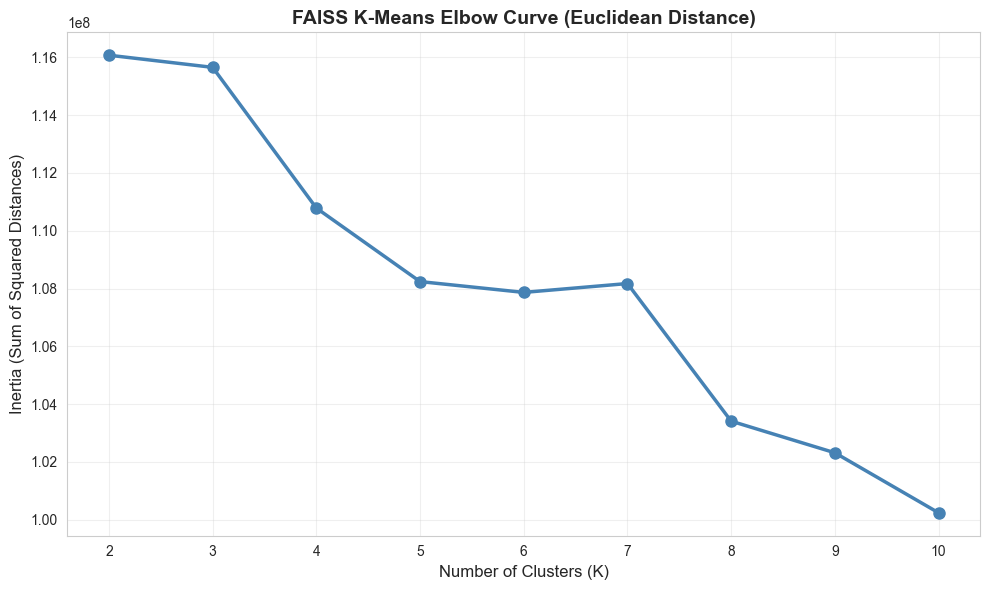


💡 Suggested K (biggest inertia drop): 4


In [17]:
import faiss
import numpy as np
import time

print("🚀 Preparing data for FAISS Euclidean K-Means clustering...\n")

# Flatten the 3D time series into 2D vectors for FAISS
# Shape: (n_users, n_timepoints * n_features)
vectors = time_series_normalized.reshape(n_users, -1).astype('float32')

dimension = vectors.shape[1]
print(f"✅ Vectors prepared:")
print(f"   Shape: {vectors.shape}")
print(f"   Dimension: {dimension} (= {n_timepoints} timepoints × {n_features} features)")
print(f"   Data type: {vectors.dtype}")
print(f"   Memory: {vectors.nbytes / 1024**2:.1f} MB")

# Test different K values with FAISS K-Means
k_range = range(2, 11)
inertias_faiss = []
timings_faiss = []

print(f"\n🎯 Testing FAISS K-Means for K={list(k_range)}...\n")

for k in k_range:
    print(f"  K={k}...", end='', flush=True)
    t_start = time.time()
    
    # FAISS K-Means
    kmeans = faiss.Kmeans(
        d=dimension,
        k=k,
        niter=20,
        verbose=False,
        gpu=False,
        seed=42
    )
    
    kmeans.train(vectors)
    
    # Get inertia (sum of squared distances to centroids)
    distances, labels = kmeans.index.search(vectors, 1)
    inertia = distances.sum()
    
    elapsed = time.time() - t_start
    timings_faiss.append(elapsed)
    inertias_faiss.append(inertia)
    
    print(f" [{elapsed:.1f}s] Inertia: {inertia:.2e}", flush=True)

print(f"\n✅ FAISS K-Means evaluation complete!")
print(f"Total time: {sum(timings_faiss)/60:.1f} minutes")
print(f"Average time per K: {np.mean(timings_faiss):.1f} seconds")

# Plot elbow curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias_faiss, marker='o', linewidth=2.5, markersize=8, color='steelblue')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('FAISS K-Means Elbow Curve (Euclidean Distance)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Find elbow point (simple method: look for biggest drop)
inertia_diffs = np.diff(inertias_faiss)
suggested_k = k_range[np.argmin(inertia_diffs) + 1]
print(f"\n💡 Suggested K (biggest inertia drop): {suggested_k}")

🎯 Running final FAISS K-Means with K=4...


✅ Final clustering complete in 0.9s

✅ Final clustering complete in 0.9s

💾 Cluster assignments saved to: C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\clustering\data\faiss_cluster_assignments_k4.parquet

📊 Cluster Distribution:
cluster
0    505833
1    292692
2    346665
3    133988
Name: count, dtype: int64

Cluster sizes: [505833, 292692, 346665, 133988]

📈 Cluster Characteristics (Average Activity per Cluster):

💾 Cluster assignments saved to: C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\clustering\data\faiss_cluster_assignments_k4.parquet

📊 Cluster Distribution:
cluster
0    505833
1    292692
2    346665
3    133988
Name: count, dtype: int64

Cluster sizes: [505833, 292692, 346665, 133988]

📈 Cluster Characteristics (Average Activity per Cluster):
 Cluster   Size  Avg Notes  Avg Ratings  Avg Requests  Avg Distance to Centroid
       0 505833  

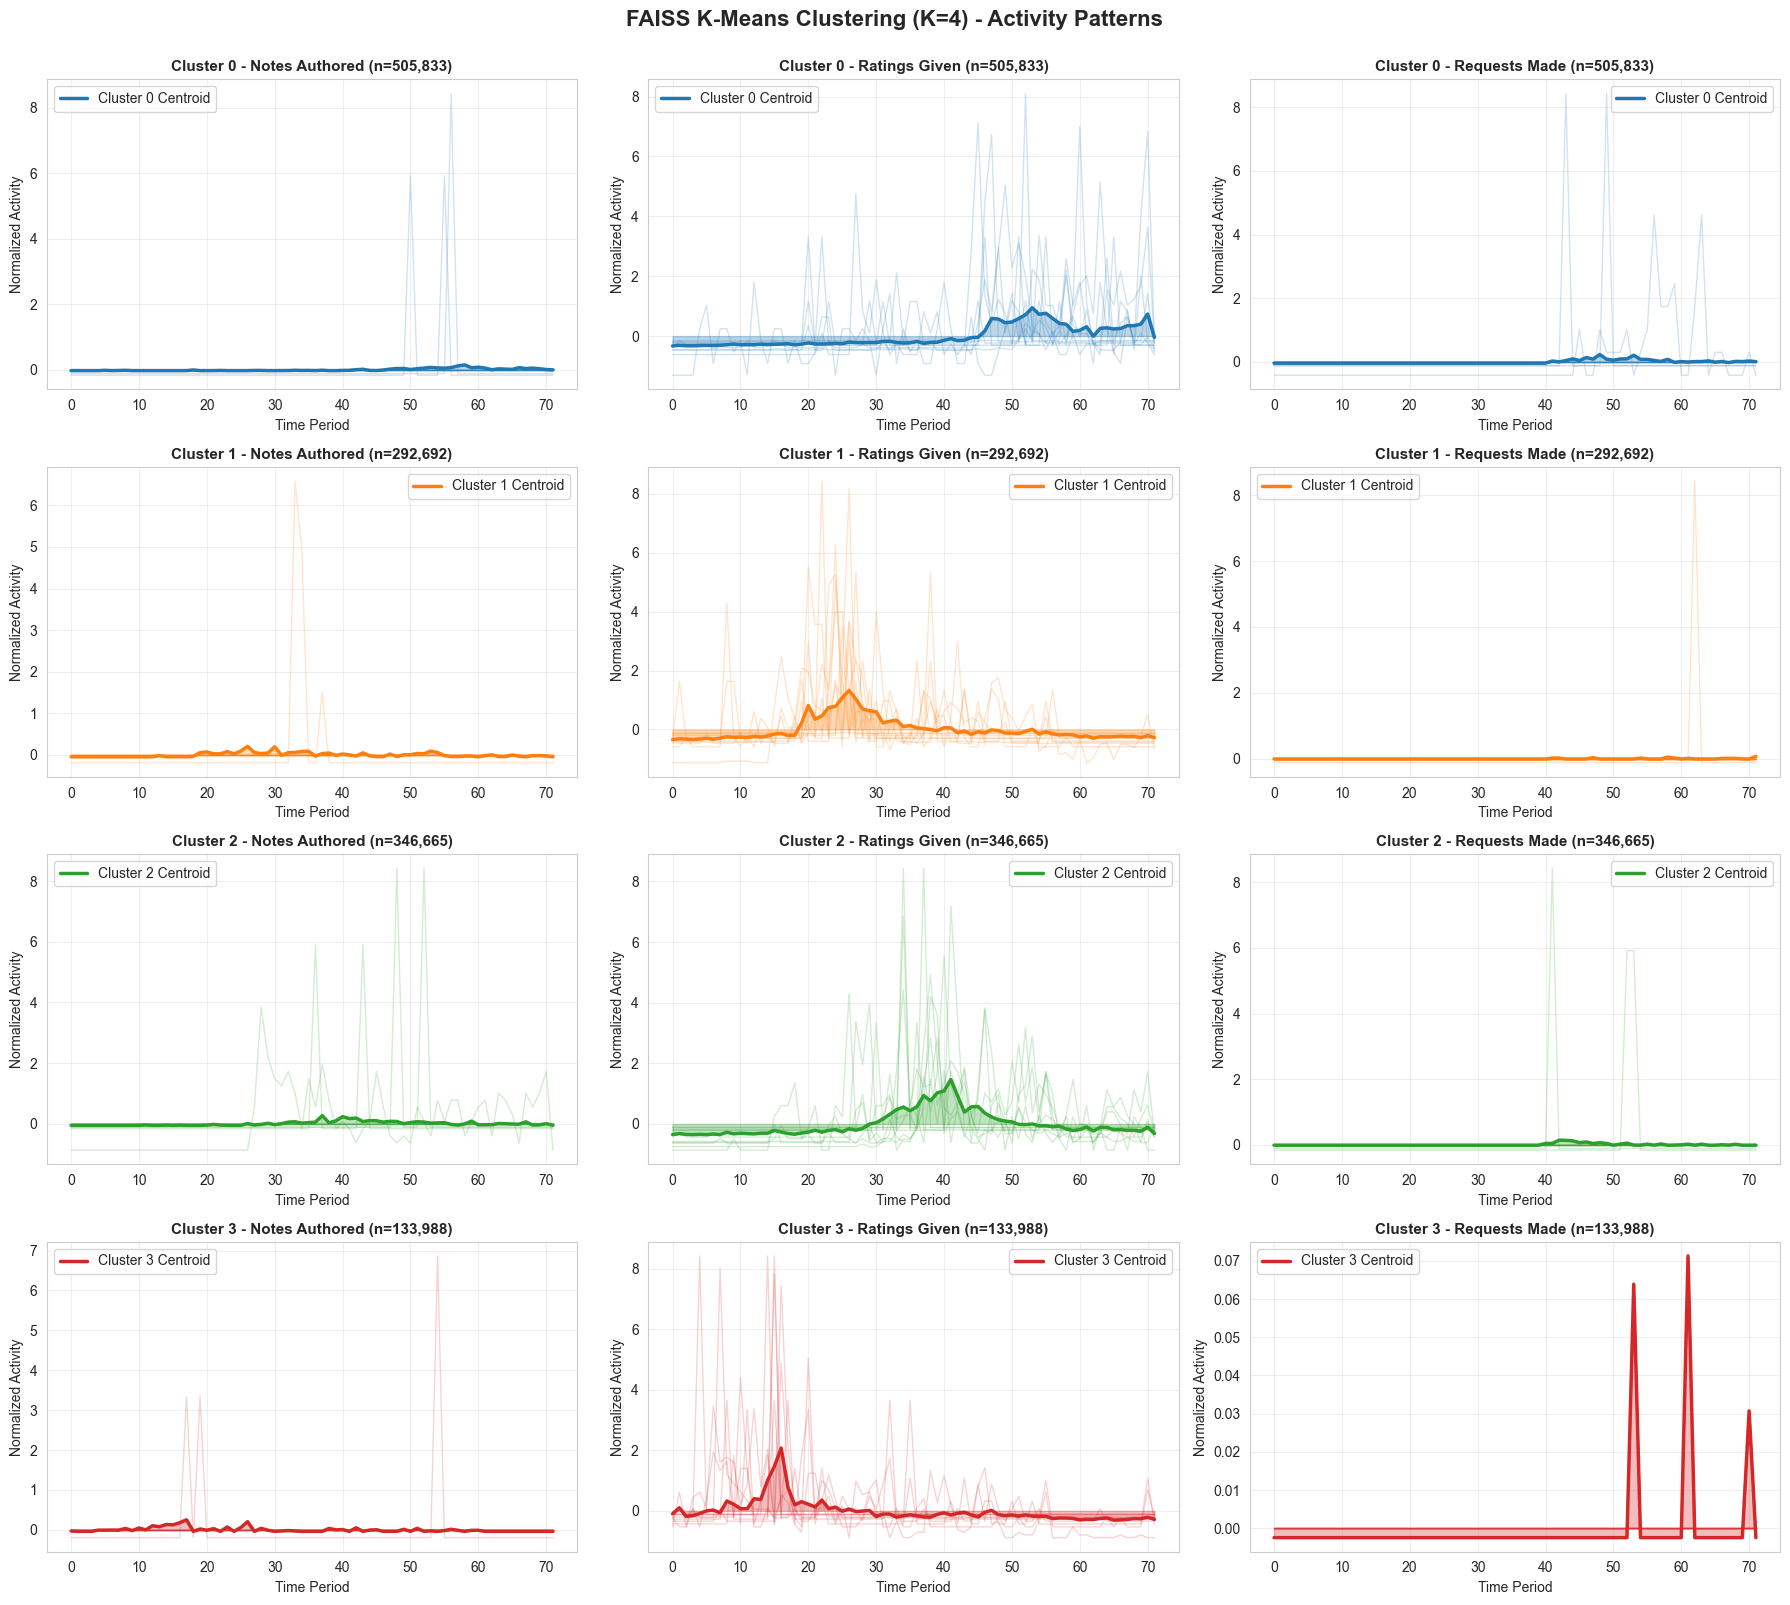


✅ Final clustering visualization complete!

🎉 You now have 4 distinct user behavior clusters!


In [18]:
import faiss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🎯 Running final FAISS K-Means with K=4...\n")

optimal_k = 4
t_start = time.time()

# Train final FAISS K-Means model
kmeans_final = faiss.Kmeans(
    d=dimension,
    k=optimal_k,
    niter=50,  # More iterations for final model
    verbose=True,
    gpu=False,
    seed=42
)

kmeans_final.train(vectors)

# Get cluster assignments and distances
distances, cluster_labels = kmeans_final.index.search(vectors, 1)
cluster_labels = cluster_labels.flatten()

elapsed = time.time() - t_start
print(f"\n✅ Final clustering complete in {elapsed:.1f}s")

# Create results DataFrame
cluster_results = pd.DataFrame({
    'userId': active_users_list,
    'cluster': cluster_labels,
    'distance_to_centroid': distances.flatten()
})

# Save cluster assignments
clustering_base = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\clustering\data"
results_path = os.path.join(clustering_base, f"faiss_cluster_assignments_k{optimal_k}.parquet")
cluster_results.to_parquet(results_path)
print(f"\n💾 Cluster assignments saved to: {results_path}")

# Cluster statistics
print("\n📊 Cluster Distribution:")
cluster_counts = cluster_results['cluster'].value_counts().sort_index()
print(cluster_counts)
print(f"\nCluster sizes: {cluster_counts.tolist()}")

# Compute cluster characteristics from original time series data
print("\n📈 Cluster Characteristics (Average Activity per Cluster):")
cluster_chars = []
for c in range(optimal_k):
    cluster_mask = cluster_labels == c
    cluster_ts = time_series_data[cluster_mask]  # Use raw data for interpretability
    
    avg_notes = cluster_ts[:, :, 0].mean()
    avg_ratings = cluster_ts[:, :, 1].mean()
    avg_requests = cluster_ts[:, :, 2].mean()
    
    cluster_chars.append({
        'Cluster': c,
        'Size': cluster_mask.sum(),
        'Avg Notes': round(avg_notes, 2),
        'Avg Ratings': round(avg_ratings, 2),
        'Avg Requests': round(avg_requests, 2),
        'Avg Distance to Centroid': round(distances[cluster_mask].mean(), 2)
    })

cluster_summary = pd.DataFrame(cluster_chars)
print(cluster_summary.to_string(index=False))

# Visualize cluster centroids over time
fig, axes = plt.subplots(optimal_k, 3, figsize=(18, 4*optimal_k))
colors = plt.cm.tab10(range(optimal_k))
feature_names = ['Notes Authored', 'Ratings Given', 'Requests Made']

# Get centroids and reshape back to time series format
centroids = kmeans_final.centroids.reshape(optimal_k, n_timepoints, n_features)

for i in range(optimal_k):
    cluster_size = (cluster_labels == i).sum()
    
    for j, feature_name in enumerate(feature_names):
        # Plot centroid
        axes[i, j].plot(range(n_timepoints), centroids[i, :, j], 
                       linewidth=2.5, color=colors[i], label=f'Cluster {i} Centroid')
        axes[i, j].fill_between(range(n_timepoints), centroids[i, :, j], 
                               alpha=0.3, color=colors[i])
        
        # Add sample trajectories from this cluster
        cluster_mask = cluster_labels == i
        sample_size = min(10, cluster_mask.sum())
        sample_idx = np.random.choice(np.where(cluster_mask)[0], sample_size, replace=False)
        for idx in sample_idx:
            axes[i, j].plot(range(n_timepoints), time_series_normalized[idx, :, j], 
                           alpha=0.2, linewidth=1, color=colors[i])
        
        axes[i, j].set_title(f'Cluster {i} - {feature_name} (n={cluster_size:,})', 
                            fontweight='bold', fontsize=11)
        axes[i, j].set_xlabel('Time Period', fontsize=10)
        axes[i, j].set_ylabel('Normalized Activity', fontsize=10)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend()

plt.suptitle(f'FAISS K-Means Clustering (K={optimal_k}) - Activity Patterns', 
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

print("\n✅ Final clustering visualization complete!")
print(f"\n🎉 You now have {optimal_k} distinct user behavior clusters!")

🎨 Creating 2D visualizations of clusters...

Using 50,000 sampled users for visualization

Step 1/2: Computing PCA (2D projection)...
  ✓ Explained variance: 10.06%
Step 2/2: Computing t-SNE (2D projection)...
  (This may take a few minutes...)
  ✓ Done!
  ✓ Done!


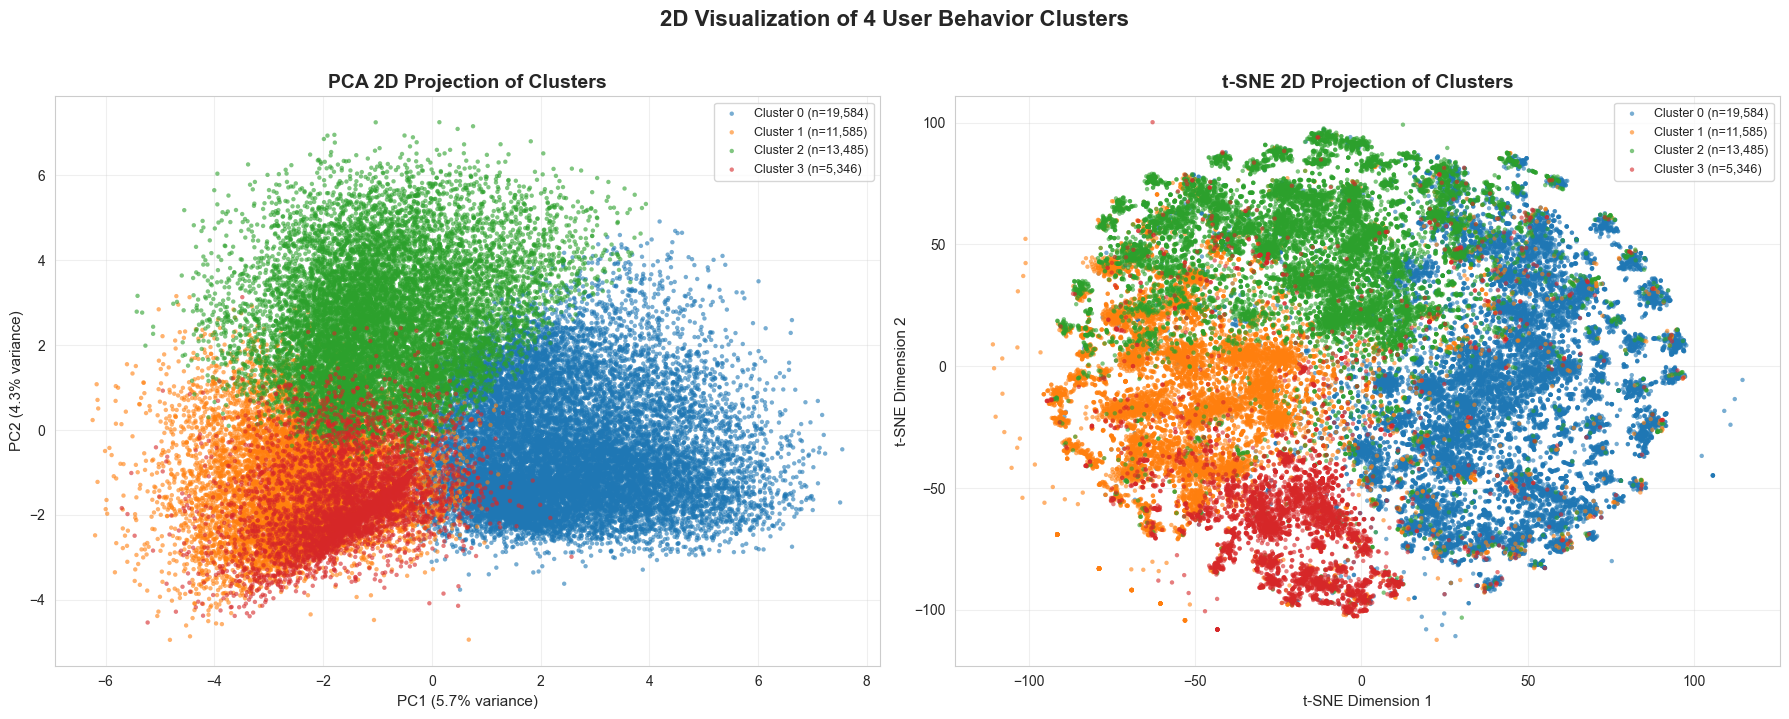


✅ 2D visualizations complete!

📊 Interpretation:
  • PCA: Shows linear relationships - clusters along main variance directions
  • t-SNE: Shows non-linear relationships - better cluster separation
  • Each dot = 1 user (showing 50,000 of 1,279,178 total)


In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🎨 Creating 2D visualizations of clusters...\n")

# Prepare data: use flattened normalized vectors
X = vectors  # Already flattened in previous cell

# Subsample for t-SNE (it's slow on large datasets)
sample_size = min(50000, n_users)
sample_idx = np.random.choice(n_users, sample_size, replace=False)
X_sample = X[sample_idx]
labels_sample = cluster_labels[sample_idx]

print(f"Using {sample_size:,} sampled users for visualization\n")

# Method 1: PCA (fast, linear)
print("Step 1/2: Computing PCA (2D projection)...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)
print(f"  ✓ Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Method 2: t-SNE (slower, non-linear, better separation)
print("Step 2/2: Computing t-SNE (2D projection)...")
print("  (This may take a few minutes...)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=0)
X_tsne = tsne.fit_transform(X_sample)
print("  ✓ Done!")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = plt.cm.tab10(range(optimal_k))

# Plot 1: PCA
for i in range(optimal_k):
    mask = labels_sample == i
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[colors[i]], label=f'Cluster {i} (n={mask.sum():,})',
                   alpha=0.6, s=10, edgecolors='none')
axes[0].set_title('PCA 2D Projection of Clusters', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: t-SNE
for i in range(optimal_k):
    mask = labels_sample == i
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   c=[colors[i]], label=f'Cluster {i} (n={mask.sum():,})',
                   alpha=0.6, s=10, edgecolors='none')
axes[1].set_title('t-SNE 2D Projection of Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'2D Visualization of {optimal_k} User Behavior Clusters', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ 2D visualizations complete!")
print("\n📊 Interpretation:")
print("  • PCA: Shows linear relationships - clusters along main variance directions")
print("  • t-SNE: Shows non-linear relationships - better cluster separation")
print(f"  • Each dot = 1 user (showing {sample_size:,} of {n_users:,} total)")

📊 Checking PCA variance across more components...



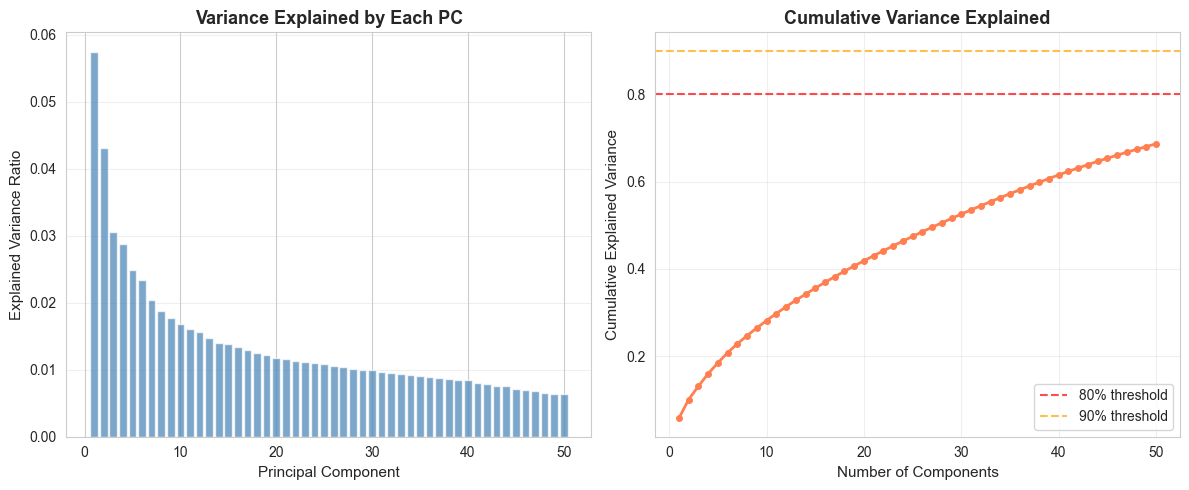

Components needed for 80% variance: 1
Components needed for 90% variance: 1
Variance explained by first 2 PCs: 10.06%
Variance explained by first 10 PCs: 28.15%
Variance explained by first 50 PCs: 68.67%


In [20]:
# Check cumulative variance explained by more components
print("📊 Checking PCA variance across more components...\n")

pca_full = PCA(n_components=50, random_state=42)
pca_full.fit(X_sample)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(12, 5))

# Plot 1: Individual variance
plt.subplot(1, 2, 1)
plt.bar(range(1, 51), pca_full.explained_variance_ratio_[:50], alpha=0.7, color='steelblue')
plt.xlabel('Principal Component', fontsize=11)
plt.ylabel('Explained Variance Ratio', fontsize=11)
plt.title('Variance Explained by Each PC', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative variance
plt.subplot(1, 2, 2)
plt.plot(range(1, 51), cumulative_variance[:50], marker='o', linewidth=2, markersize=4, color='coral')
plt.axhline(y=0.8, color='red', linestyle='--', label='80% threshold', alpha=0.7)
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold', alpha=0.7)
plt.xlabel('Number of Components', fontsize=11)
plt.ylabel('Cumulative Explained Variance', fontsize=11)
plt.title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
n_for_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_for_90 = np.argmax(cumulative_variance >= 0.9) + 1

print(f"Components needed for 80% variance: {n_for_80}")
print(f"Components needed for 90% variance: {n_for_90}")
print(f"Variance explained by first 2 PCs: {pca_full.explained_variance_ratio_[:2].sum():.2%}")
print(f"Variance explained by first 10 PCs: {cumulative_variance[9]:.2%}")
print(f"Variance explained by first 50 PCs: {cumulative_variance[49]:.2%}")